In [30]:
%matplotlib inline

In [3]:
# os contains routines for interacting with the computer's operating system
# thing like listing directories

import os

# numpy is a fantastic set of tools for working with sets of numerical data
# the "as np" at the end is an abbreviation we can use so we don't have to 
# keep typing "numpy"

import numpy as np

# pandas is the standard python tool for handling spreadsheets 
# we will use it a lot

import pandas as pd

# matplotlib is the main plotting library we will use
import matplotlib.pyplot as plt


### This notebook begins our analysis of data from the following paper

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878611/pdf/839.pdf

#### How many biological replicates are needed in an RNA-seq experiment and which differential expression tool should you use?

RNA-seq is now the technology of choice for genome-wide differential gene expression experiments, but it is not clear how many biological replicates are needed to ensure valid biological interpretation of the results or which statistical tools are best for analyzing the data. An RNA-seq experiment with 48 biological replicates in each of two conditions was performed to answer these questions and provide guidelines for experimental design. With three biological replicates, nine of the 11 tools evaluated found only 20%–40% of the significantly differentially expressed (SDE) genes identified with the full set of 42 clean replicates. This rises to >85% for the subset of SDE genes changing in expression by more than fourfold. To achieve >85% for all SDE genes regardless of fold change requires more than 20 biological replicates. The same nine tools successfully control their false discovery rate at ≲5% for all numbers of replicates, while the remaining two tools fail to control their FDR adequately, particularly for low numbers of replicates. For future RNA-seq experiments, these results suggest that at least six biological replicates should be used, rising to at least 12 when it is important to identify SDE genes for all fold changes. If fewer than 12 replicates are used, a superior combination of true positive and false positive performances makes edgeR and DESeq2 the leading tools. For higher replicate numbers, minimizing false positives is more important and DESeq marginally outperforms the other tools.

### Datafiles

There are 96 separate datafiles, each representing the processed output of an RNAseq experiment looking at mRNA levels in wild-type (48 samples) or SNF2 deletion (48 samples) yeast cells grown under standard condition. 

The files are incredible simple. Two columns, separated by tabs. The first column is the gene name, the second column the normalized counts for that gene in that sample (read the paper if you're interested in how they did the counting and normalization).

```
YBL013W 39
YBL014C 127
YBL015W 732
YBL016W 309
YBL017C 1613
YBL018C 174
YBL019W 117
YBL020W 258
YBL021C 248
YBL022C 1168
YBL023C 331
YBL024W 451
YBL025W 64
YBL026W 206
YBL027W 9723
YBL028C 77
YBL029C-A       157
```

Most of the genes have this naming format:

Systematic names for nuclear-encoded ORFs begin with the letter 'Y' (for 'Yeast'); the second letter denotes the chromosome number ('A' is chr I, 'B' is chr II, etc.); the third letter is either 'L' or 'R' for left or right chromosome arm; next is a three digit number indicating the order of the ORFs on that arm of a chromosome starting from the centromere, irrespective of strand; finally, there is an additional letter indicating the strand, either 'W' for Watson (the strand with 5' end at the left telomere) or 'C' for Crick (the complement strand, 5' end is at the right telomere).

You can read about the yeast gene naming system here - http://seq.yeastgenome.org/help/community/nomenclature-conventions. 

### Preprocessing

The next few cells are about loading in the raw data in individual files and turning it into a single tab-delimited file. You can ignore this stuff and skip ahead to the section on "Loading Data"


In [11]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of data frames
#

# this is a list of dataframes that I add to as I load data

frames = []

rawdatadir = "data/barton/rawdata/"
for file in os.listdir(rawdatadir):
    if file.endswith(".gbgout"):
        filepath = os.path.join(rawdatadir, file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        
        #
        # load in the dataframe giving the gene column the name "Gene"
        # and uses the filename as the column name
        # this will be important when we merge things together later
        #
        
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))
        
        # drop last 5 rows which are junk from the file
        frames[-1].drop(frames[-1].tail(5).index,inplace=True) 
        
        

In [12]:
#
# the list frames is a list of dataframes 
# here is an example of what one of them looks like
#

frames[0].head()

,Gene,Snf2_rep39
0,15S_rRNA,7
1,21S_rRNA,64
2,HRA1,5
3,ICR1,286
4,LSR1,250


To join these together into a single file we will take advantage of Pandas' powerful dataframe merging function called 'merge'

You can read about merge here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

The great thing about merge is that you can take two dataframes (loaded from separate files) that have some column in common, and create a new dataframe that uses the shared column as its 'key' and then puts the data in the individual files together to make a new dataframe.

In our case we're going to do an "outer" merge using the "Gene" field as our key. And outer merge creates a row in the new dataframe for every unique value of the "Gene" field across the two input files and creates a new column for every column (except the key) in the two dataframes that are being merged and copies the value from the original column into the new dataframe. The most useful thing about this function is that if there is a gene in one file but not another, it will create a row for this gene, and leave a blank where there is missing data.

In [14]:
#
# This command will merge together the first two dataframes 
#

pd.merge(frames[0],frames[1], on=['Gene'], how='outer').head(10)

,Gene,Snf2_rep39,WT_rep18
0,15S_rRNA,7,55
1,21S_rRNA,64,270
2,HRA1,5,0
3,ICR1,286,134
4,LSR1,250,411
5,NME1,38,44
6,PWR1,0,0
7,Q0010,0,0
8,Q0017,0,0
9,Q0032,0,0


In [31]:
#
# this is a complex command that takes the list of files in frames
# and merges them into one dataframe, combining on the "Gene" column
#

from functools import reduce

df10 = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames[0:5])
df10 = df10.loc[df10['Gene'].str.startswith('Y')]
df10 = df10.set_index('Gene')
df10.to_csv("data/barton/Barton_combined_Ygenes_10.txt", sep='\t')

In [62]:
#
# this is a complex command that takes the list of files in frames
# and merges them into one dataframe, combining on the "Gene" column
#

from functools import reduce

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)



In [63]:
#
# make sure it looks right
#

df.head()

,Gene,Snf2_rep39,WT_rep18,WT_rep17,Snf2_rep31,Snf2_rep43,Snf2_rep35,Snf2_rep28,Snf2_rep08,Snf2_rep30,...,Snf2_rep16,Snf2_rep17,Snf2_rep11,Snf2_rep23,Snf2_rep06,Snf2_rep33,WT_rep44,WT_rep02,WT_rep37,WT_rep36
0,15S_rRNA,7,55,25,5,85,172,13,4,29,...,5,50,7,8,3,16,12,12,1,21
1,21S_rRNA,64,270,119,45,576,579,192,33,170,...,38,391,64,39,62,76,58,76,29,193
2,HRA1,5,0,6,4,0,4,0,4,1,...,2,2,3,0,1,3,2,2,4,0
3,ICR1,286,134,129,102,202,140,151,160,123,...,175,203,191,157,146,239,81,123,111,85
4,LSR1,250,411,206,81,742,713,199,96,265,...,137,439,157,175,522,306,81,163,100,223


In [69]:
#
# Sort columns by name for convenience
#
cols = ['Gene']
cols += sorted([c for c in list(df.columns) if c.startswith("WT")])
cols += sorted([c for c in list(df.columns) if c.startswith("Snf2")])

df = df.reindex(cols, axis=1)

In [70]:
df.head()

,Gene,WT_rep01,WT_rep02,WT_rep03,WT_rep04,WT_rep05,WT_rep06,WT_rep07,WT_rep08,WT_rep09,...,Snf2_rep39,Snf2_rep40,Snf2_rep41,Snf2_rep42,Snf2_rep43,Snf2_rep44,Snf2_rep45,Snf2_rep46,Snf2_rep47,Snf2_rep48
0,15S_rRNA,2,12,31,8,21,11,2,3,7,...,7,15,6,1,85,8,34,3,6,3
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,64,79,67,13,576,52,234,23,44,24
2,HRA1,3,2,2,2,3,5,4,0,4,...,5,5,0,2,0,1,2,2,0,1
3,ICR1,75,123,107,157,98,245,119,120,119,...,286,155,184,164,202,186,148,183,195,145
4,LSR1,60,163,233,163,193,375,194,84,211,...,250,195,153,57,742,227,227,117,224,136


In [71]:
#
# Use only genes starting with "Y" which are protein-coding genes
# You can come back and revisit this choice later if you want
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [72]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [74]:
df[df.columns[0:6]].to_csv("data/barton/temp.tsv",sep="\t")

In [73]:
# Save so we don't have to do all that again next time

df.to_csv("data/barton/Barton_combined_Ygenes.tsv", sep='\t')

### Loading Data

Pandas is great because you can load in all sorts of types of data (including Excel spreadsheets!) into it with a simple command. We saves the file avove as a "tsv" or "tab separated values" file, which saves every row of the table as a string with values in each column separated by tabs.

Here is what the first six columns of this file looks like:

```
Gene    WT_rep01        WT_rep02        WT_rep03        WT_rep04        WT_rep05        WT_rep06
YAL001C 311     421     382     550     403     929
YAL002W 266     451     434     616     441     913
YAL003W 6387    10292   7440    12994   11001   16296
YAL004W 0       0       0       0       0       0
YAL005C 10331   10088   10932   19029   9711    18561
YAL007C 596     895     787     1180    836     1682
YAL008W 278     357     346     596     290     591
YAL009W 205     291     238     371     251     570
YAL010C 179     341     281     423     262     581
YAL011W 216     383     288     397     375     759
YAL012W 4251    3737    3007    5536    4111    8171
YAL013W 776     962     717     1097    1062    1913
YAL014C 840     923     717     1136    939     1592
YAL015C 318     346     291     490     347     577
YAL016C-A       17      29      24      30      19      35
```


In [75]:
# 
# it's very easy to load a tsv file in
# you use the Pandas read_csv commans (I know seems weird to use csv, but that's the way they did it)
# the sep = "\t" tells it the fields are separated by tabs -- the default is commas but I think that looks ugly
# 

#
# THIS IS ALL YOU NEED TO KNOW TO LOAD DATA INTO PANDAS
# IT'S SUPER SUPER EASY 
#

df = pd.read_csv("data/barton/Barton_combined_Ygenes.tsv", sep="\t")


# 
# you don't need to do this, but this tells Pandas to use the column "Gene" as its index
# this will allow us to retrieve rows by their gene name easily and fast
#

df = df.set_index("Gene")

In [76]:
#
# look at loaded file
# the .head(10) says only show first 10 lines
#

df.head(10)

,WT_rep01,WT_rep02,WT_rep03,WT_rep04,WT_rep05,WT_rep06,WT_rep07,WT_rep08,WT_rep09,WT_rep10,...,Snf2_rep39,Snf2_rep40,Snf2_rep41,Snf2_rep42,Snf2_rep43,Snf2_rep44,Snf2_rep45,Snf2_rep46,Snf2_rep47,Snf2_rep48
Gene,,,,,,,,,,,,,,,,,,,,,
YAL001C,311,421,382,550,403,929,499,414,379,482,...,1235,641,673,562,734,773,611,911,749,667
YAL002W,266,451,434,616,441,913,503,431,376,507,...,851,529,406,367,555,623,436,586,556,445
YAL003W,6387,10292,7440,12994,11001,16296,10198,10137,11298,8425,...,11071,6280,7442,5177,7664,6827,7081,7010,6800,5943
YAL004W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL005C,10331,10088,10932,19029,9711,18561,12207,16760,12184,10562,...,15617,8459,9813,8600,11531,8748,9513,11423,7835,8836
YAL007C,596,895,787,1180,836,1682,948,890,811,871,...,2338,1099,1226,1042,1526,1254,1308,1564,1431,1236
YAL008W,278,357,346,596,290,591,317,392,431,380,...,888,483,658,391,686,578,489,543,556,461
YAL009W,205,291,238,371,251,570,285,297,298,359,...,745,398,476,311,433,484,365,468,491,437
YAL010C,179,341,281,423,262,581,250,268,316,321,...,726,372,400,316,432,535,369,459,441,354


### Fun with Data Frames

you can do all sorts of cool things with Pandas dataframes


In [80]:
#
# let's start by getting the data for one gene
#

df.loc['YAL001C'].head(10)

WT_rep01    311
WT_rep02    421
WT_rep03    382
WT_rep04    550
WT_rep05    403
WT_rep06    929
WT_rep07    499
WT_rep08    414
WT_rep09    379
WT_rep10    482
Name: YAL001C, dtype: int64

In [81]:
#
# we can get this as a series like above which has the index in it
# or a simple list of numbers
#

df.loc['YAL001C'].values


array([ 311,  421,  382,  550,  403,  929,  499,  414,  379,  482,  235,
        418,  539,  584,  415,  232,  456,  467,  396,  292,  458,  645,
        505,  423,  538,  512,  580,  557,  413,  863,  482,  304,  408,
        353,  432,  309,  353,  264,  353,  696,  492,  445,  419,  289,
        541,  292,  647,  409,  840,  653,  823, 1036,  510,  820, 1240,
        549,  828,  738,  711,  594,  699,  914,  411,  675,  712,  753,
        575,  603,  837,  504,  775, 1179,  467,  825,  544,  586,  740,
        568,  440,  782, 1131,  754,  621,  570,  753,  616, 1235,  641,
        673,  562,  734,  773,  611,  911,  749,  667])

In [83]:
#
# lets assign this numbers to a variable
#

genedata = df.loc['YAL001C'].values


#
# once we have the numbers we can do all sorts of things with them
#

#
# we can get some statistics
#

print ("Mean of data is :", np.mean(genedata))
print ("Standard deviation of data is :", np.std(genedata))


Mean of data is : 590.8125
Standard deviation of data is : 216.5260912155469


(array([ 9., 18., 14., 19., 12., 13.,  6.,  1.,  1.,  3.]),
 array([ 232. ,  332.8,  433.6,  534.4,  635.2,  736. ,  836.8,  937.6,
        1038.4, 1139.2, 1240. ]),
 <a list of 10 Patch objects>)

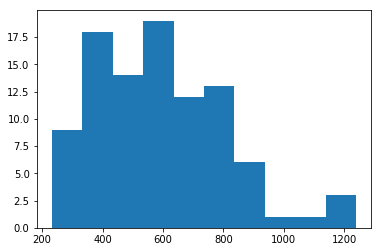

In [84]:
#
# we can also plot these data
#

#
# the obvious thing to do with a single list of values like this is to 
# make a histogram
#

plt.hist(genedata)

Text(0.5,1,'Histogram of expression of YAL001C')

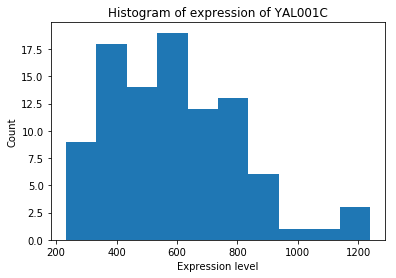

In [86]:
#
# you should get into good habits of labeling your axes
#

plt.hist(genedata)
plt.xlabel("Expression level")
plt.ylabel("Count")
plt.title("Histogram of expression of YAL001C")

Text(0.5,1,'Histogram of expression of YAL001C')

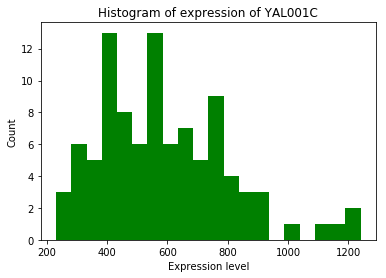

In [88]:
#
# you can change all sorts of things about plots
# bins controls the number of divisions of the data 
# 

plt.hist(genedata, bins=20, color='green')
plt.xlabel("Expression level")
plt.ylabel("Count")
plt.title("Histogram of expression of YAL001C")

In [91]:
#
# we can also get data for an entire column
#

expdata = df['WT_rep01']

In [92]:
expdata.head(10)

Gene
YAL001C      311
YAL002W      266
YAL003W     6387
YAL004W        0
YAL005C    10331
YAL007C      596
YAL008W      278
YAL009W      205
YAL010C      179
YAL011W      216
Name: WT_rep01, dtype: int64

Text(0,0.5,'WT_rep02')

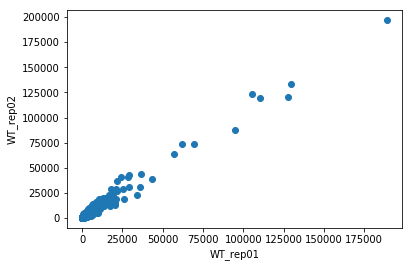

In [126]:
#
# but histograms don't really tell us much about experiments
# so lets compare two different experiments
#

x = df['WT_rep01']
y = df['WT_rep02']

plt.scatter(x,y)
plt.xlabel("WT_rep01")
plt.ylabel("WT_rep02")

Text(0,0.5,'WT_rep02')

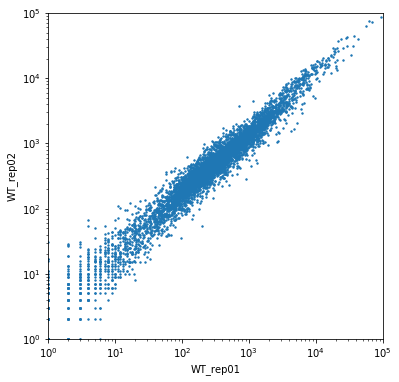

In [133]:
#
# a few things to make this prettier
#

x = df['WT_rep01']
y = df['WT_rep02']

# first lets make it square

plt.figure(figsize=(6,6))

# lets make the points smaller

plt.scatter(x,y,s=2)

# and lets use a log scale to spread out the cluster of points in lower left corner

plt.xscale("log")
plt.yscale("log")

# and set the limits 

plt.xlim(1,100000)
plt.ylim(1,100000)


plt.xlabel("WT_rep01")
plt.ylabel("WT_rep02")

In [137]:
#
# we can ask how correlated these two datasets are
#

from scipy.stats.stats import pearsonr 

print (pearsonr(df['WT_rep01'],df['WT_rep02']))

#
# the two reported values are correlation and p-value
#

# we can set these to variables

(corr,pval) = pearsonr(df['WT_rep01'],df['WT_rep02'])

(0.9854605405768926, 0.0)


In [157]:
#
# because of the way the data are clustered at low values let's do some
# filetering and then do the correlation on log values
#

df = df[(df > 50).all(axis=1)]

print (pearsonr(np.log(df['WT_rep01']),np.log(df['WT_rep02'])))

#
# the two reported values are correlation and p-value
#

# we can set these to variables

(corr,pval) = pearsonr(df['WT_rep01'],df['WT_rep02'])

(0.9626914389698933, 0.0)


### Your assignment

I want you to make a histogram of all of the correlation coefficients between ALL pairs of different experiments. It should end up looking something like this:

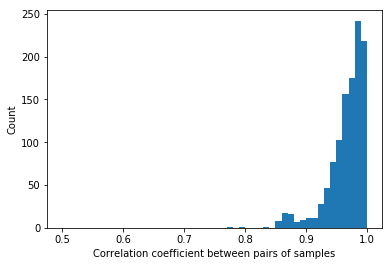

As homework, make histograms comparing pairs of samples from same experiment (e.g. WT vs WT and Snf2 vs Snf2) to cross sample types (WT vs Snf2). We will use this kind of analysis on Thursday.